# Productivity Prediction - Garment Employees 

. It is a Regression problem.

. We will estimate the productivity based on available features.


## Importing all necessary modules & libraries

In [1]:
#Importing all the required libraries
import pandas as pd                #for reading csv
import numpy as np
import matplotlib.pyplot as plt    #for visualization
import seaborn as sns

import warnings                    #to avoid warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split  #for splitting data set to train and test

# Importing libraries for Machine Learning Models.

from sklearn.linear_model import LinearRegression    
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV    # for hypertuning of Machine Learning models
from sklearn.metrics import mean_squared_error #calculating MSE
from sklearn.metrics import r2_score 
import joblib   #save the model for later

## Data overview

In [2]:
data=pd.read_csv("garments_worker_productivity.csv",sep=',')
data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


AttributeError: module 'pandas' has no attribute 'Dataframe'

In [3]:
data_10 = data.copy()

# Data Cleaning & Exploratory Data Analysis(Insights of Data )

In [4]:
data.shape

(1197, 15)

In [5]:
data=data.drop_duplicates()

In [6]:
data.shape

(1197, 15)

There is no duplicates in this data.

In [7]:
data.dtypes

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

In [8]:
data['date'] = data['date'].astype('datetime64')

In [9]:
data.dtypes

date                     datetime64[ns]
quarter                          object
department                       object
day                              object
team                              int64
targeted_productivity           float64
smv                             float64
wip                             float64
over_time                         int64
incentive                         int64
idle_time                       float64
idle_men                          int64
no_of_style_change                int64
no_of_workers                   float64
actual_productivity             float64
dtype: object

In [10]:
# Categorical columns and Numerical columns are separated .

category = data.select_dtypes(include='object')
numeric = data.select_dtypes(exclude=['object','datetime64'])

## Categorical features

In [11]:
for c in category.columns:
    print(f"{c}")
    print(category[c].unique())
    print()

quarter
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']

department
['sweing' 'finishing ' 'finishing']

day
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']



In [12]:
# Spelling Correcting
data['department'] = data['department'].replace({'finishing ': 'finishing', 'sweing' : 'sewing'})

In [13]:
# Check each quarter wise counts
data['quarter'].value_counts()

Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64

 There are 5 quarter as quarter 1, quarter 2, quarter 3, quarter 4, quarter 5, and quarter 5 which is not evenly distributed

In [14]:
# Check the reason for why Quarter 5 not evenly distributed
data_1=data[data['quarter']=='Quarter5']
data_1['date'].nunique()

2

There is only 2 days in Quarter 5 (2015-01-29,2015-01-31)

In [15]:
# Check each days wise counts
data['day'].value_counts()

Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: day, dtype: int64

 From this,Friday is not a working day

In [16]:
# Check each department counts
dept = data.department.value_counts().reset_index()
dept.rename(columns = {'index':'department', 'department':'total_num'},inplace=True)
dept

,department,total_num
0,sewing,691
1,finishing,506


There are 2 department sewing and finishing and the data consist of 691 sewing observations and 506 finishng observations

In [17]:
# Checking Department wise average Productivity
df = data.groupby(['department']).actual_productivity.mean()
df

department
finishing    0.752951
sewing       0.722013
Name: actual_productivity, dtype: float64

In [18]:
# To check the number of teams in each departments and their avg over time
overtime_team_department = data.groupby(['department', 'team']).mean()['over_time']
overtime_team_department

department  team
finishing   1       1888.163265
            2       1983.461538
            3       2774.594595
            4       2758.695652
            5       2115.428571
            6       1527.428571
            7       1896.585366
            8       1581.509434
            9       1260.000000
            10      2009.302326
            11      1651.034483
            12      1588.500000
sewing      1       7335.535714
            2       6575.789474
            3       7035.000000
            4       7547.796610
            5       7271.379310
            6       4461.610169
            7       7064.181818
            8       6896.785714
            9       7103.793103
            10      6794.210526
            11      5665.423729
            12      4490.423729
Name: over_time, dtype: float64

There are 12 teams for both finishing and sewing

## Numerical Features

In [19]:
data.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


In [20]:
data.no_of_workers.sum()

41428.0

In [21]:
dat=data.groupby(['department']).no_of_workers.sum()
dat

department
finishing     5188.0
sewing       36240.0
Name: no_of_workers, dtype: float64

### Data Visualization

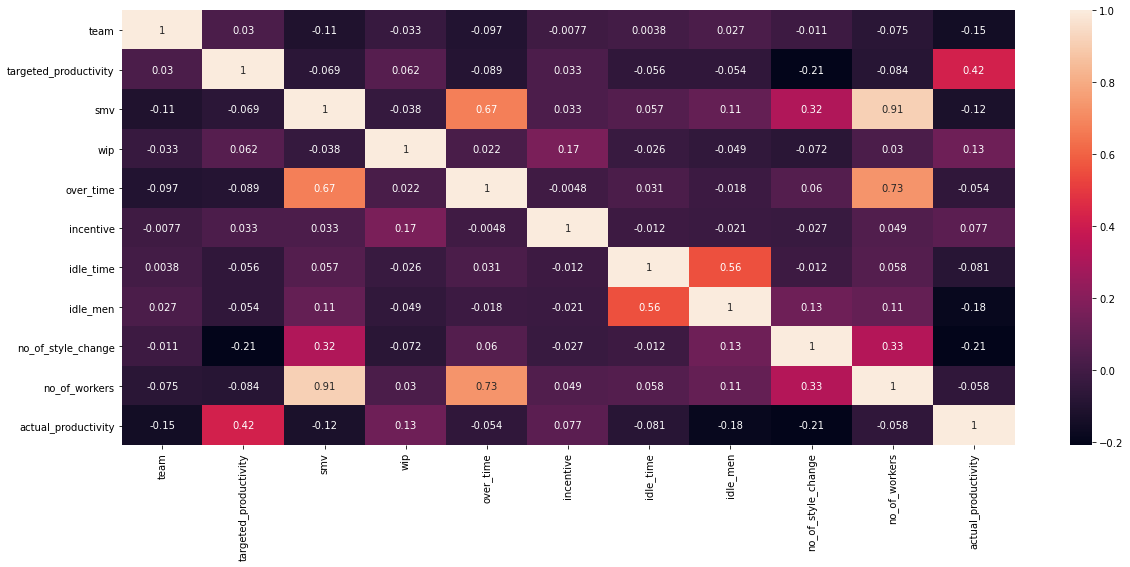

In [22]:
# Correlation between the features
plt.figure(figsize = (20,8))
sns.heatmap(data.corr(), annot=True);

Highest Positive Correlations:

   . No_of workers and smv((the allocated time for a task) (0.91)  
   . No_of workers and over_time (0.73)   
   . Over_time and smv (0.67)  
   . Idle_men and Idle_time (0.56).    


<AxesSubplot:xlabel='targeted_productivity', ylabel='Density'>

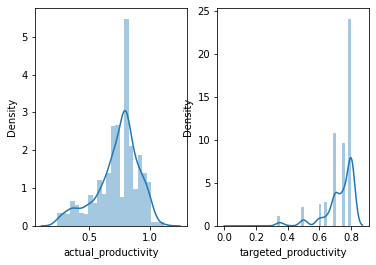

In [23]:
# Distribution of actual productivity
plt.subplot(1, 2, 1)
sns.distplot(data['actual_productivity'])
# Distribution of targeted productivity
plt.subplot(1, 2, 2)
sns.distplot(data['targeted_productivity'])

### Histogram of features

array([[<AxesSubplot:title={'center':'team'}>,
        <AxesSubplot:title={'center':'targeted_productivity'}>,
        <AxesSubplot:title={'center':'smv'}>],
       [<AxesSubplot:title={'center':'wip'}>,
        <AxesSubplot:title={'center':'over_time'}>,
        <AxesSubplot:title={'center':'incentive'}>],
       [<AxesSubplot:title={'center':'idle_time'}>,
        <AxesSubplot:title={'center':'idle_men'}>,
        <AxesSubplot:title={'center':'no_of_style_change'}>],
       [<AxesSubplot:title={'center':'no_of_workers'}>,
        <AxesSubplot:title={'center':'actual_productivity'}>,
        <AxesSubplot:>]], dtype=object)

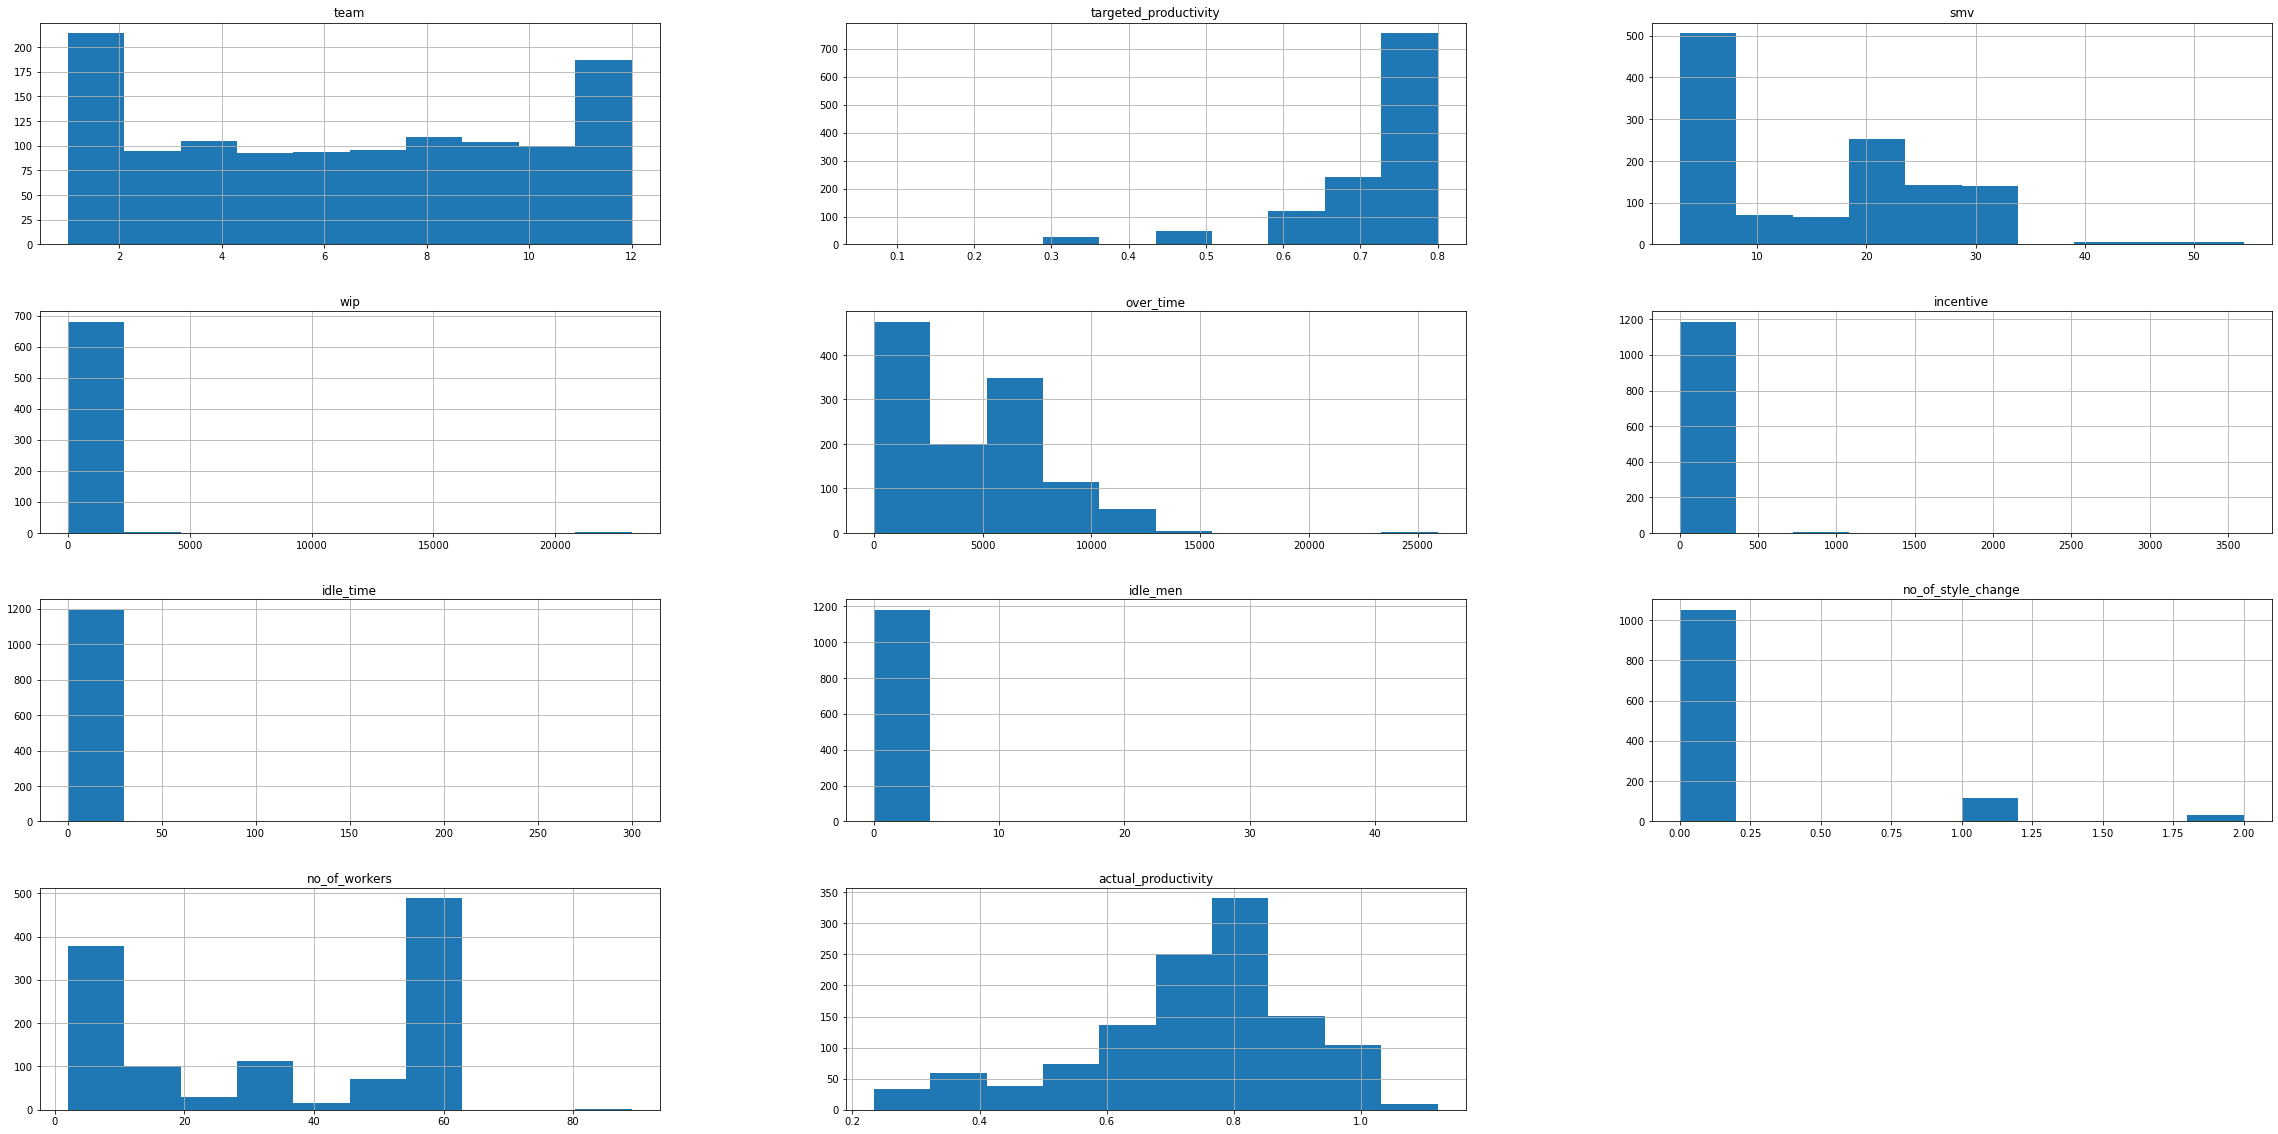

In [24]:
data.hist(figsize = (40,20))

<AxesSubplot:xlabel='no_of_workers', ylabel='smv'>

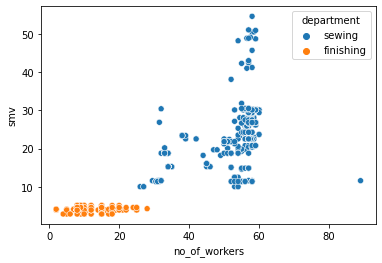

In [25]:
# Scatter plot no_of_workers vs smv w.r.t department
splot=sns.scatterplot(data=data, x="no_of_workers", y="smv", hue="department")
splot

 For the finising department smv(the allocated time for a task) does not change with no_of_workers

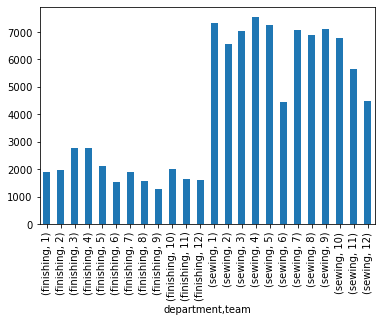

In [26]:
# To check the number of teams in each departments and their average over time
overtime_team_department = data.groupby(['department', 'team']).mean()['over_time']
overtimeplot = overtime_team_department.plot.bar()
plt.show()

Finishing department has relatively lower over_time values regarding sweing department. In sweing department team6, team11 and team12 have the lowest over_time values.

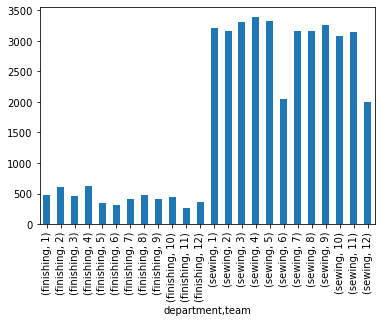

In [27]:
# To check the number of teams in each departments and their sum()no_of_workers.
o_team_department = data.groupby(['department', 'team']).no_of_workers.sum()
no_of_workersplot = o_team_department.plot.bar()
plt.show()

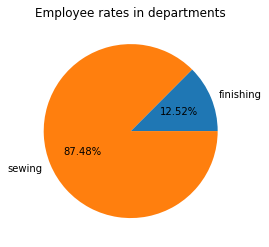

In [28]:
# Checking Employee rates in each departments
data_dep_workers = data.groupby(['department']).no_of_workers.sum()
data_dep_workers.plot.pie(title="Employee rates in departments",autopct='%.2f%%')
plt.ylabel(None)
plt.show()

In [29]:
data_dep_workers

department
finishing     5188.0
sewing       36240.0
Name: no_of_workers, dtype: float64

Emloyees in sewing is more than employees in finishing

Text(0.5, 0, 'no_of_style_change')

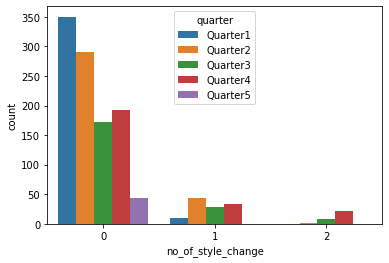

In [30]:
# count of no_of_style_change in each quater
sns.countplot('no_of_style_change',hue='quarter',data=data)
plt.xlabel('no_of_style_change')


Text(0.5, 0, 'no_of_style_change')

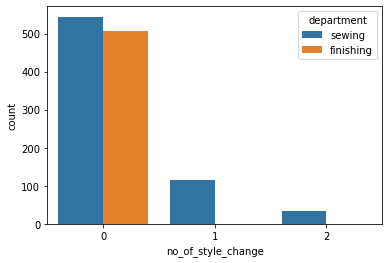

In [31]:
# count of no_of_style_change in each dept
sns.countplot('no_of_style_change',hue='department',data=data)
plt.xlabel('no_of_style_change')

 There is no no_of_style_change in Quarter5 and it is only in sewing.There is no style change in finishing

### Bar Chart of features w.r.t departments 

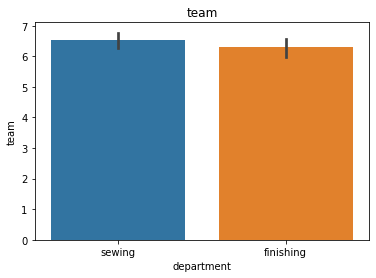

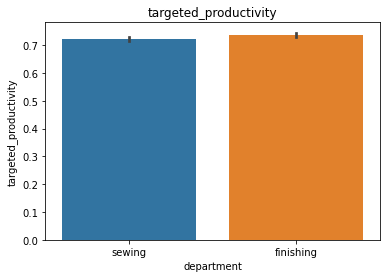

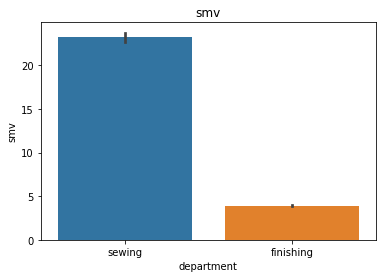

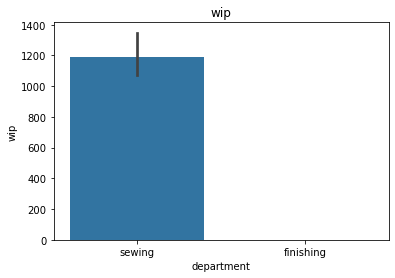

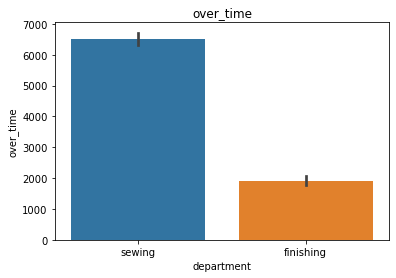

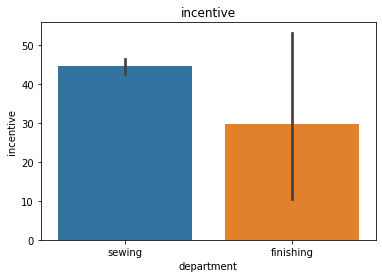

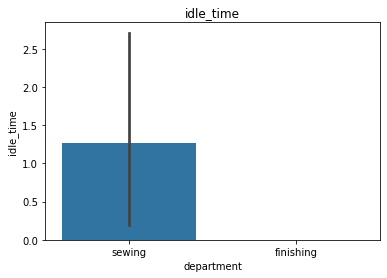

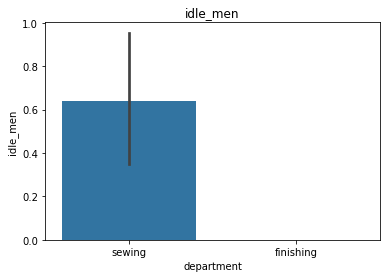

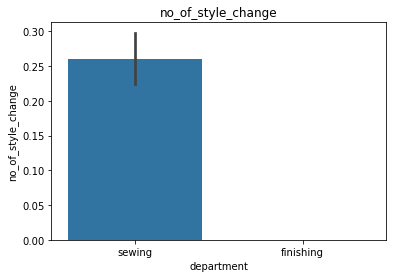

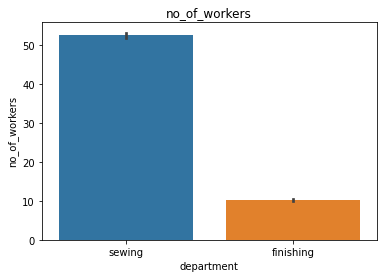

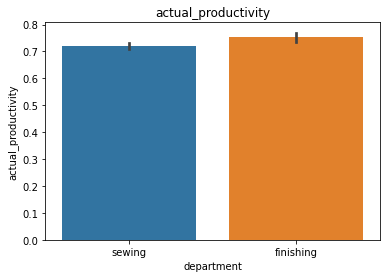

In [32]:
for d in numeric.columns:
    sns.barplot(y=d, x = data.department,data=data)
    plt.title(d)
    plt.show()

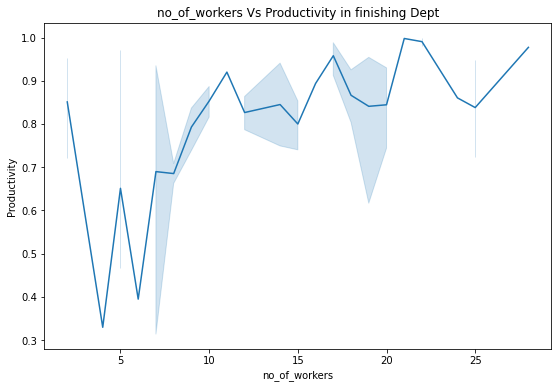

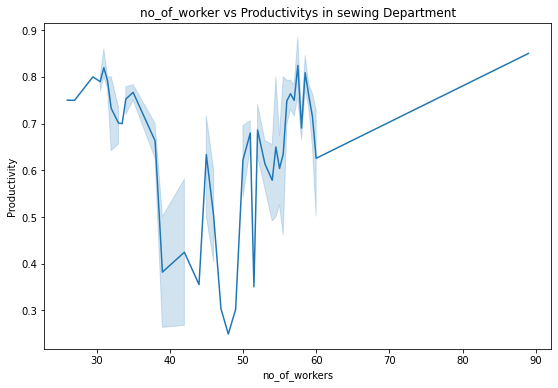

In [33]:
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
fw = data['no_of_workers'].where(data['department']=='finishing')
ax=sns.lineplot(y= 'actual_productivity',x=fw,data=data,legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.title( 'no_of_workers Vs Productivity in finishing Dept')
plt.show()
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 2)
sw = data['no_of_workers'].where(data['department']=='sewing')
ax=sns.lineplot(y= 'actual_productivity',x=sw,data=data,legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.title( 'no_of_worker vs Productivitys in sewing Department')
plt.show()

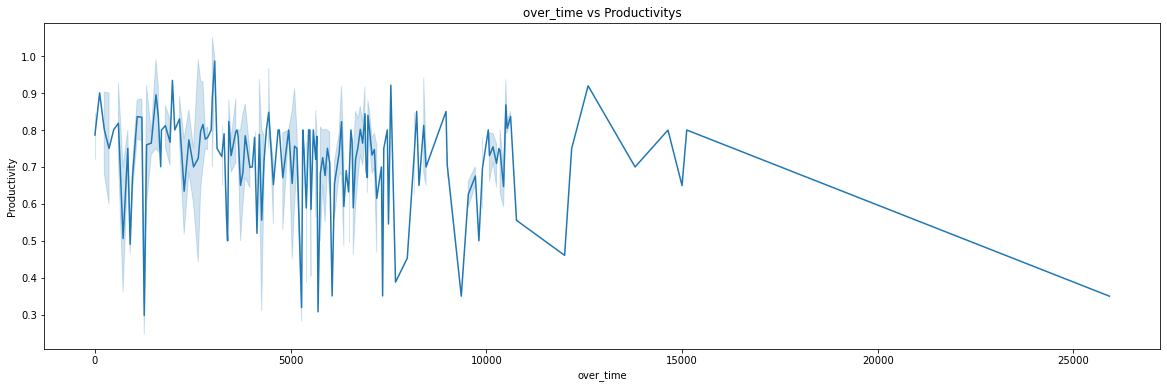

In [34]:
plt.figure(figsize = (20,6))
ax=sns.lineplot(y= 'actual_productivity',x='over_time',data=data,legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.title( 'over_time vs Productivitys')
plt.show()

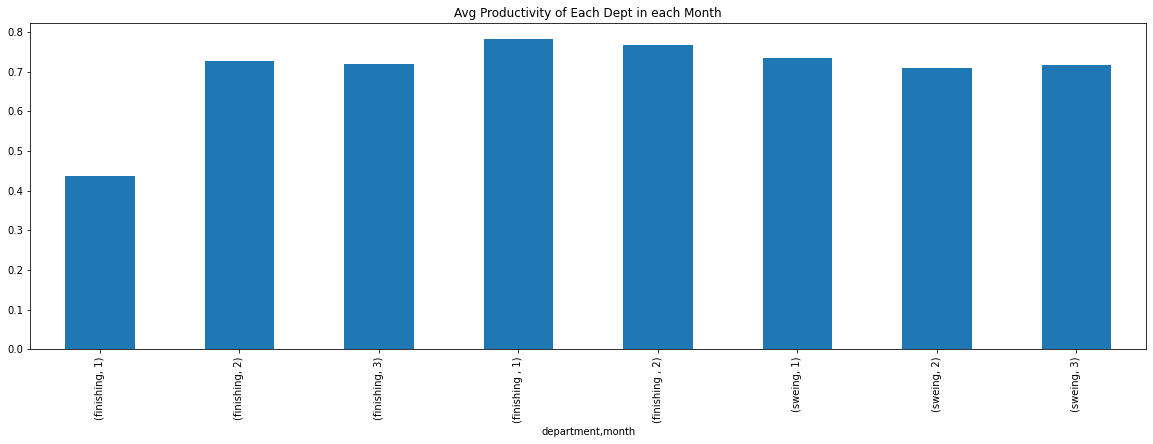

In [35]:
data_10[["month", "day", "year"]] = data_10["date"].str.split("/", expand = True)
data_10.drop(['day','year'],axis=1)
dma=data_10.groupby(['department', 'month']).mean()['actual_productivity']
plt.figure(figsize = (20,6))
dmaplot = dma.plot.bar()
plt.title('Avg Productivity of Each Dept in each Month')
plt.show()

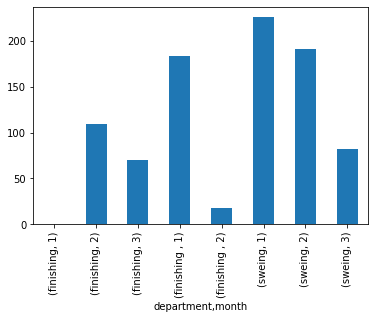

In [36]:
o_team_department = data_10.groupby(['department', 'month']).actual_productivity.sum()
no_of_workersplot = o_team_department.plot.bar()
plt.show()

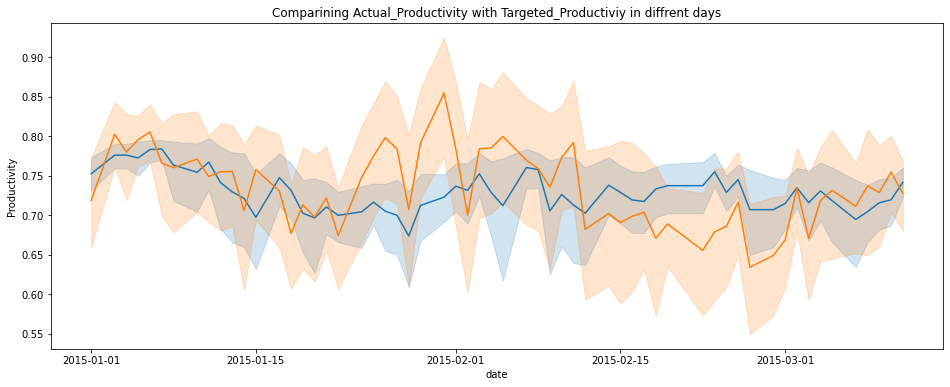

In [37]:
plt.figure(figsize = (16,6))
ax=sns.lineplot(y='targeted_productivity',x='date' ,data =data,legend='brief')
ax=sns.lineplot(y= 'actual_productivity',x='date',data=data,legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.title('Comparining Actual_Productivity with Targeted_Productiviy in diffrent days')
plt.show()

There are both negative and positive variations in targeted_productivity from actual_productivity

# Misssing value handling

In [38]:
data.isna().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [39]:
data_1=data[data['wip'].isna()]
data_1['department'].unique()

array(['finishing'], dtype=object)

In [40]:
data2=data[data['department']=='finishing']
data2.shape

(506, 15)

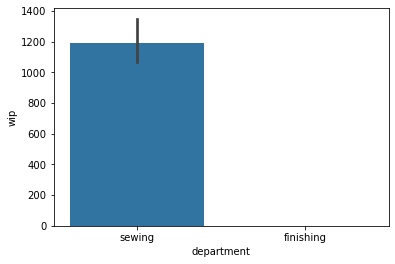

In [41]:
bplot=sns.barplot(y='wip',x = data.department,data=data)
plt.show()

All null values belongs to the finishing department. ( The finishing department needs to get a work from the sewing department. This result could mean that the finishing department has no work in progress while waiting for work from the sewing department.).So we can replace all 506 null values with zeros.

In [42]:
data['wip'].fillna(0, inplace=True)
data.isna().sum()


date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64

# Handling Outliers

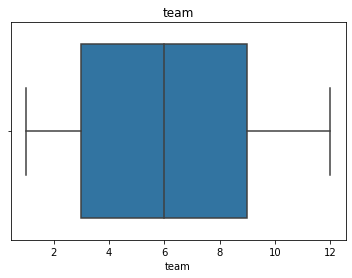

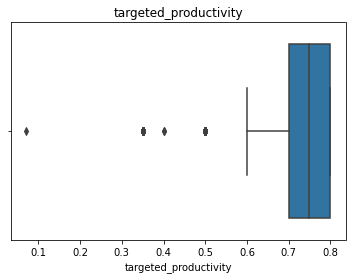

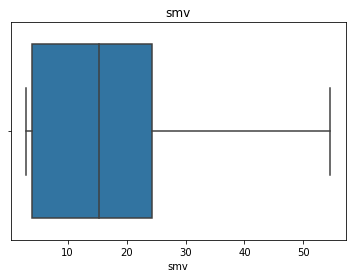

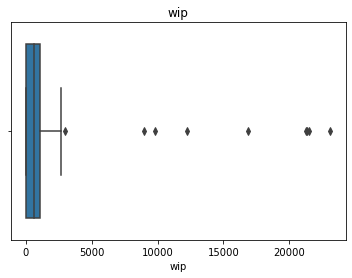

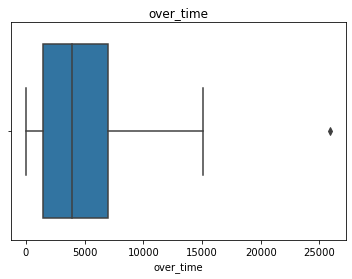

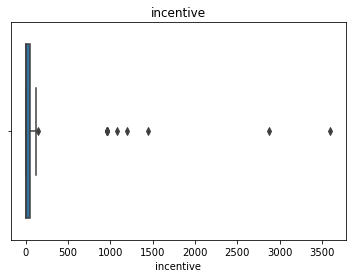

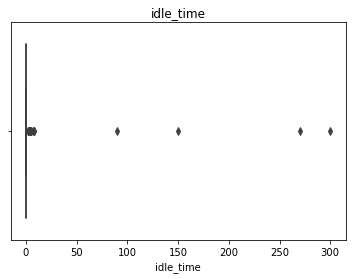

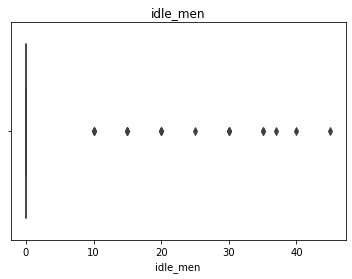

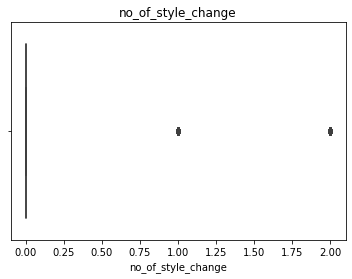

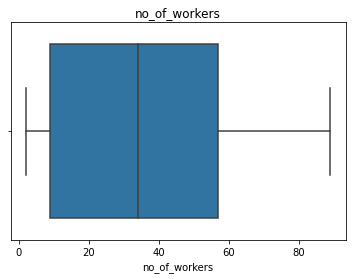

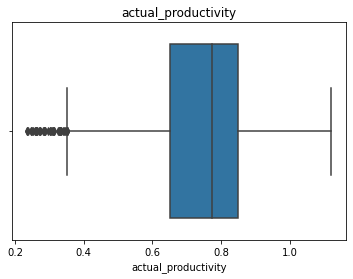

In [43]:
for x in numeric.columns:
    sns.boxplot(data[x],orient='h')
    plt.title(x)
    plt.show()

From the above Boxplot we infer there are outliers for the  "targeted_productivity","actual_productivity","over_time""incentive","wip", "idle_time", "idle_men" and "no_of_style_change".So we remove the Columns with outliers.

In [44]:
num_cols = ["targeted_productivity","actual_productivity","over_time","incentive","wip", "idle_time", "idle_men"] # Columns with outliers to be eliminated

In [45]:
for x in num_cols:
    print(x)
    descr = data[x].describe()
    IQR = descr['75%'] - descr['25%']
    upper_limit =  descr['75%'] + 1.5 * IQR
    lower_limit =  descr['25%'] - 1.5 * IQR  
    #outlier replacement
    data[x][data[x]>upper_limit] = upper_limit
    data[x][data[x]<lower_limit] = lower_limit

targeted_productivity
actual_productivity
over_time
incentive
wip
idle_time
idle_men


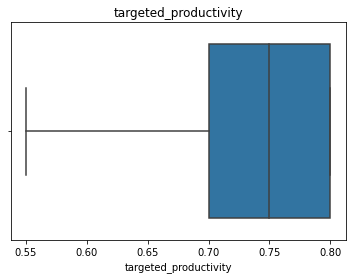

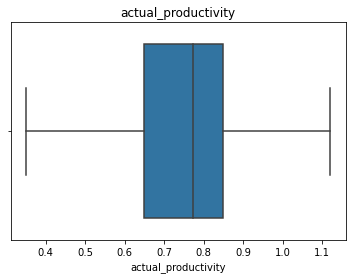

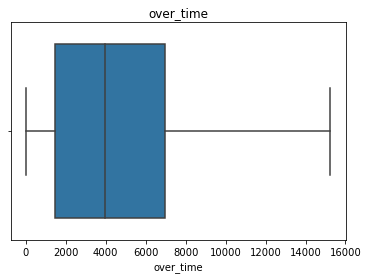

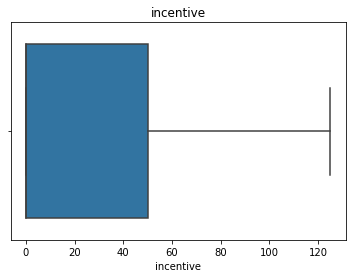

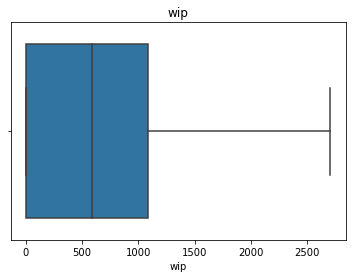

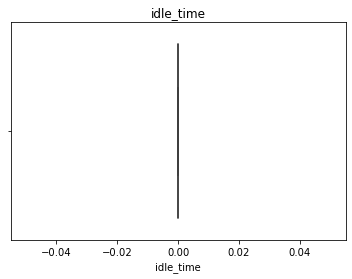

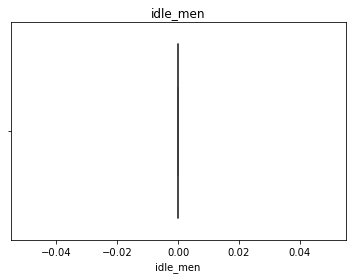

In [46]:
for x in num_cols:
    sns.boxplot(data[x],orient='h')
    plt.title(x)
    plt.show()

In [47]:
#sns.boxplot(x='department',y='over_time',data=data)
#plt.show()

In [48]:
testdata=data.copy()

# Dropping unwanted columns from the dataset

In [49]:
data = data.drop(['date','idle_time','idle_men'],axis=1)
data.shape

(1197, 12)

# Encoding

In [50]:
category.columns

Index(['quarter', 'department', 'day'], dtype='object')

In [51]:
print("quarter",data["quarter"].nunique())
print("department",data["department"].nunique())
print("day",data["day"].nunique())
print("team",data["team"].nunique())
print('no_of_style_change',data['no_of_style_change'].nunique())

quarter 5
department 2
day 6
team 12
no_of_style_change 3


In [52]:
dat = pd.get_dummies(data, columns=['quarter', 'department', 'day','team','no_of_style_change'],prefix=['quarter', 'department', 'day','team','no_of_style_change'])


In [53]:
# features managements
data=pd.get_dummies(dat)
data

,targeted_productivity,smv,wip,over_time,incentive,no_of_workers,actual_productivity,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,...,team_6,team_7,team_8,team_9,team_10,team_11,team_12,no_of_style_change_0,no_of_style_change_1,no_of_style_change_2
0,0.80,26.16,1108.0,7080,98,59.0,0.940725,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0.75,3.94,0.0,960,0,8.0,0.886500,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.80,11.41,968.0,3660,50,30.5,0.800570,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0.80,11.41,968.0,3660,50,30.5,0.800570,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0.80,25.90,1170.0,1920,50,56.0,0.800382,1,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,0.75,2.90,0.0,960,0,8.0,0.628333,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1193,0.70,3.90,0.0,960,0,8.0,0.625625,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1194,0.65,3.90,0.0,960,0,8.0,0.625625,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1195,0.75,2.90,0.0,1800,0,15.0,0.505889,0,1,0,...,0,0,0,1,0,0,0,1,0,0


# Splitting the data as X and Y

In [54]:
#creating X and y Datasets
y=data['actual_productivity']
X=data.drop(['actual_productivity'],axis=1)

In [55]:
X.head()

,targeted_productivity,smv,wip,over_time,incentive,no_of_workers,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,...,team_6,team_7,team_8,team_9,team_10,team_11,team_12,no_of_style_change_0,no_of_style_change_1,no_of_style_change_2
0,0.80,26.16,1108.0,7080,98,59.0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0.75,3.94,0.0,960,0,8.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.80,11.41,968.0,3660,50,30.5,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0.80,11.41,968.0,3660,50,30.5,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0.80,25.90,1170.0,1920,50,56.0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [56]:
test_data=X.copy()

In [57]:
y.head()

0    0.940725
1    0.886500
2    0.800570
3    0.800570
4    0.800382
Name: actual_productivity, dtype: float64

In [58]:
X.shape

(1197, 34)

# Splitting data for train and test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42) #0.67 data will be for training.

In [60]:
X_train.shape

(801, 34)

In [61]:
X_test.shape

(396, 34)

# Linear Regression Model

In [62]:
linear_reg = LinearRegression()           #creating LinearRegression class object and fitting the train data
linear_reg.fit(X_train,y_train)

LinearRegression()

In [63]:
y_pred_test = linear_reg.predict(X_test)
MSE_lr = mean_squared_error(y_test,y_pred_test)
RMSE_lr =np.sqrt(MSE_lr)
print("Root Mean Squared Error of Linear Regression:",RMSE_lr)

Root Mean Squared Error of Linear Regression: 0.14079529970226956


In [64]:
y_pred_train = linear_reg.predict(X_train)
MSE_training_lr = mean_squared_error(y_train,y_pred_train)
RMSE_training_lr = np.sqrt(MSE_training_lr)
print("Root Mean Squared Error of Training- Linear Regression:",RMSE_training_lr)

Root Mean Squared Error of Training- Linear Regression: 0.12890169355591044


Here train_error is less than test error 

# Ridge Regression

In [65]:
ridge = Ridge()

In [66]:
#hyper tuning parameters of GridSearchCV
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20,30]
solver=['auto','svd','sag']
parameters = {'alpha': alpha,'solver':solver}

ridge_gridcv = GridSearchCV(ridge,parameters,cv=5)
ridge_gridcv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20, 30],
                         'solver': ['auto', 'svd', 'sag']})

In [67]:
#list of paramters available for GridSearchCV
#ridge_gridcv.get_params().keys()

In [68]:
#Best parameters 
ridge_gridcv.best_params_

{'alpha': 0.01, 'solver': 'svd'}

In [69]:
#Retraining the ridge regressor with best parameters
ridge=Ridge(alpha=0.01,solver='svd')
ridge.fit(X_train,y_train)

Ridge(alpha=0.01, solver='svd')

In [70]:
#prediction of y values and calculating the error
y_pred_ridge=ridge.predict(X_test)
MSE_ridge = mean_squared_error(y_pred_ridge,y_test)
RMSE_ridge = np.sqrt(MSE_ridge)
print("Root Mean Squared Error Ridge Regressor:",RMSE_ridge)

Root Mean Squared Error Ridge Regressor: 0.14078851341948653


In [71]:
#prediction of y values and calculating the train_error
#y_pred_ridge_train=ridge.predict(X_train)
#MSE_ridge = mean_squared_error(y_pred_ridge_train,y_train)
#RMSE_ridge_train = np.sqrt(MSE_ridge)
#print("Root Mean Squared Error Ridge Regressor:",RMSE_ridge_train)

# Lasso Regression


In [72]:
lasso = Lasso() 

In [73]:
#hyper tuning parameters of GridSearchCV
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20,30]
parameters = {'alpha': alpha}

lasso_gridcv = GridSearchCV(lasso,parameters,cv=5)
lasso_gridcv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20, 30]})

In [74]:
#Best parameters 
lasso_gridcv.best_params_

{'alpha': 0.0001}

In [75]:
#Retraining the Lasso regressor with best parameters
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)

Lasso(alpha=0.0001)

In [76]:
#prediction of y values and calculating the error
y_pred_lasso=lasso.predict(X_test)
MSE_lasso = mean_squared_error(y_pred_lasso,y_test)
RMSE_lasso = np.sqrt(MSE_lasso)
print("Root Mean Squared Error Lasso Regressor:",RMSE_lasso)

Root Mean Squared Error Lasso Regressor: 0.14041619836062005


In [77]:
#prediction of y values and calculating the train_error
#y_pred_lasso_train=lasso.predict(X_train)
#MSE_lasso = mean_squared_error(y_pred_lasso_train,y_train)
#RMSE_lasso_train = np.sqrt(MSE_lasso)
#print("Root Mean Squared Error Lasso Regressor:",RMSE_lasso_train)

# ElasticNet Regression

In [78]:
elastic = ElasticNet()                            #creating object of ElasticNet Regressor

In [79]:
#hyper tuning parameters of GridSearchCV
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
parameters = {'alpha': alpha}

elastic_gridcv = GridSearchCV(elastic, parameters,cv=5)
elastic_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]})

In [80]:
#Best parameters 
elastic_gridcv.best_params_

{'alpha': 0.0001}

In [81]:
#Retraining the elasticnet regressor with best parameters
elastic = ElasticNet(alpha=0.0001) 
elastic.fit(X_train,y_train)

ElasticNet(alpha=0.0001)

In [82]:
#prediction of y values and calculating the error
y_pred_elastic=elastic.predict(X_test)
MSE_elastic = mean_squared_error(y_pred_elastic,y_test)
RMSE_elastic = np.sqrt(MSE_elastic)
print("Root Mean Squared Error ElasticNet Regressor:",RMSE_elastic)

Root Mean Squared Error ElasticNet Regressor: 0.1405798821432438


In [83]:
#MSE
elastic_Error=mean_squared_error(y_pred_elastic,y_test)
elastic_Error

0.01976270326340832

In [84]:
#prediction of y values and calculating the training_error
#y_pred_elastic_train=elastic.predict(X_train)
#MSE_elastic = mean_squared_error(y_pred_elastic_train,y_train)
#RMSE_elastic_train = np.sqrt(MSE_elastic)
#print("Root Mean Squared Error ElasticNet Regressor:",RMSE_elastic_train)

# Random_forest Regresser

In [85]:
random_forest = RandomForestRegressor() 

In [86]:
#hyper tuning parameters of GridSearchCV
lst=[]
for i in range (1,101):
    lst.append(i)    
n_estimators=lst
criterion=['mse']
max_depth=[3,5,10]
random_state = [42]
parameters={'n_estimators':n_estimators,'criterion':criterion,'max_depth':max_depth,'random_state':random_state}

radom_forest_gridcv = GridSearchCV(random_forest, parameters)
radom_forest_gridcv.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': [3, 5, 10],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'random_state': [42]})

In [87]:
#Best parameters 
radom_forest_gridcv.best_params_

{'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100, 'random_state': 42}

In [88]:

#Retraining the RandomForest regressor with best parameters
random_forest = RandomForestRegressor(criterion= 'mse',max_depth =10,n_estimators =100,random_state=42)
random_forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [89]:
#prediction of y values and calculating the error
y_pred_randomforest = random_forest.predict(X_test)
MSE_random_forest = mean_squared_error(y_pred_randomforest,y_test)
RMSE_random_forest = np.sqrt(MSE_random_forest)
print("r2 score for Random Forest:",r2_score(y_pred_randomforest,y_test))
print("Root Mean Squared Error RandomForest Regressor:",RMSE_random_forest)

r2 score for Random Forest: -0.11238967359474694
Root Mean Squared Error RandomForest Regressor: 0.12647794294604256


# XGBoost Regresser

In [90]:

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 200)    
xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
#prediction of y values and calculating the error
y_pred_xgboost = xg_reg.predict(X_test)
MSE_xgboost= mean_squared_error(y_pred_xgboost,y_test)
RMSE_xgboost = np.sqrt(MSE_xgboost)
print("Root Mean Squared Error XGBoost Regressor:",RMSE_xgboost)

Root Mean Squared Error XGBoost Regressor: 0.14409171411183166


In [92]:
data_dmatrix = xgb.DMatrix(data=X,label=y)


In [93]:
type(data_dmatrix)

xgboost.core.DMatrix

# Error Dictionary to compare RMSE

In [94]:
ErrorDictionary ={'Linear Regression': RMSE_lr,
                 'Ridge Regression':RMSE_ridge,
                 'Lasso Regression':RMSE_lasso,
                 'ElasticNet Regression:':RMSE_elastic,
                 'RandomForest Regression:':RMSE_random_forest,
                 'XGBoost:':RMSE_xgboost}
ErrorDictionary

{'Linear Regression': 0.14079529970226956,
 'Ridge Regression': 0.14078851341948653,
 'Lasso Regression': 0.14041619836062005,
 'ElasticNet Regression:': 0.1405798821432438,
 'RandomForest Regression:': 0.12647794294604256,
 'XGBoost:': 0.14409171411183166}

# Here we can see that RandomForest Regression Model has the least Root Mean Squared Error, so we select RandomForest Model as our final model.

In [95]:
# pickle file is used to save the model for later use
joblib.dump(random_forest,'ProductivityPrediction.pkl')

['ProductivityPrediction.pkl']

In [96]:
#loading the final model
Final_model=joblib.load('ProductivityPrediction.pkl')

In [97]:
# Predicting values of test_data with final model
predict_test_data = Final_model.predict(test_data)
predict_test_data

array([0.94895944, 0.85072699, 0.80139744, ..., 0.58683098, 0.65619049,
       0.4655783 ])

In [98]:
new_df=pd.DataFrame({'Predicted_Productivity':predict_test_data})
new_df

,Predicted_Productivity
0,0.948959
1,0.850727
2,0.801397
3,0.801100
4,0.805389
...,...
1192,0.661422
1193,0.596576
1194,0.586831
1195,0.656190


In [99]:
new_df['Predicted_Productivity'].isna().sum()

0

In [100]:
dataset_test = testdata.copy()
dataset_test.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [101]:
garments_df =pd.concat([dataset_test,new_df],axis=1)
garments_df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Predicted_Productivity
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,0.948959
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,0.850727
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,0.801397
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,0.801100
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,0.805389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,Quarter2,finishing,Wednesday,10,0.75,2.90,0.0,960,0,0.0,0,0,8.0,0.628333,0.661422
1193,2015-03-11,Quarter2,finishing,Wednesday,8,0.70,3.90,0.0,960,0,0.0,0,0,8.0,0.625625,0.596576
1194,2015-03-11,Quarter2,finishing,Wednesday,7,0.65,3.90,0.0,960,0,0.0,0,0,8.0,0.625625,0.586831
1195,2015-03-11,Quarter2,finishing,Wednesday,9,0.75,2.90,0.0,1800,0,0.0,0,0,15.0,0.505889,0.656190


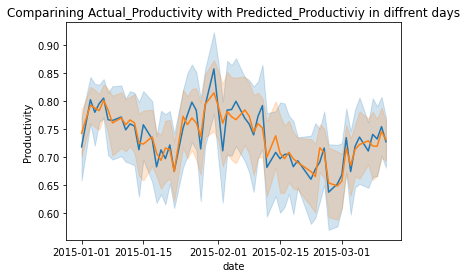

In [102]:
ad=sns.lineplot(x='date', y='actual_productivity',data=garments_df)
ad=sns.lineplot(x='date',y='Predicted_Productivity',data=garments_df)
ad.set(ylabel = 'Productivity')
plt.title('Comparining Actual_Productivity with Predicted_Productiviy in diffrent days')
plt.show()